In [1]:
#!pip install torchmetrics

In [1]:
!pip install scikeras

In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, LSTM, InputLayer
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

<ipython-input-27-80d74a26f338>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [4]:
import torch
import torch.nn
import torchvision.transforms as transforms
import torchvision.datasets
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math
from torchmetrics.regression import MeanAbsolutePercentageError

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)

if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
dpath = "/content/drive/MyDrive/FIND-A/data/"

In [8]:
fit = pd.read_csv(dpath + 'fitted_values.csv')
sent = pd.read_csv(dpath + 'sentiment_res.csv', encoding='cp949')

### 데이터 전처리

In [33]:
sent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48958 entries, 1042 to 49999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             48958 non-null  datetime64[ns]
 1   updown           48958 non-null  int64         
 2   filtered_nouns3  48958 non-null  object        
 3   sent_score       48958 non-null  float64       
 4   Year             48958 non-null  int64         
 5   Month            48958 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 2.6+ MB


In [34]:
fit.head()

,index,cpi,stock,housing_lease,housing_trading,coincident,ir,ex,land_price,gr
0,2020-02-01,100.129785,105.444674,86.067343,80.875038,100.563427,1.095067,1193.444382,0.292993,-1.531442
1,2020-03-01,100.162578,103.809292,86.161180,81.123099,100.302872,1.097569,1211.530343,0.278769,-1.343450
2,2020-04-01,99.902076,92.745528,86.191786,81.203381,99.693635,0.880210,1218.109117,0.262119,-1.223660
3,2020-05-01,99.356775,98.408421,86.179746,81.491508,98.757473,0.626974,1213.026559,0.265169,-1.862200
4,2020-06-01,99.358689,100.072573,86.196649,81.754894,98.163027,0.589962,1219.388960,0.276622,-1.405300


In [35]:
# date 열을 문자열에서 날짜로 변환
sent['date'] = pd.to_datetime(sent['date'], format='%Y-%m-%d')

# 2020년 1월 데이터가 아닌 행 필터링
sent = sent[~((sent['date'].dt.year == 2020) & (sent['date'].dt.month == 1))]

In [36]:
sent.head()

,date,updown,filtered_nouns3,sent_score,Year,Month
1042,2020-02-01,0,스포츠서울 김효원 경기도 시공사 인천 시공사 국토교통부 지자체 신도시 이름 공모전 ...,328.591639,2020,2
1043,2020-02-01,0,아파트 입찰 실수 경매 계약 포기 경매 물건 가치 잘못 평가 거나 잔금 마련 자료 ...,-205.126534,2020,2
1044,2020-02-01,0,국토 연구원 도시 정비 사업 관리 확대 방안 보고서 재건축 재개발 투명 위해 공공 ...,413.123887,2020,2
1045,2020-02-01,0,청라 힐스 건설 제공 서울 국기 분양 시장 개막 초읽기 부동산 리서치 회사 닥터 아...,-4.864725,2020,2
1046,2020-02-01,0,아시아 경제 문제 왕숙 늘빛 도시 신도시 대장 플로우 시티 국토교통부 한국 토지 주...,147.931636,2020,2


In [37]:
# 연도와 월에 대한 그룹화
sent['Year'] = sent['date'].dt.year
sent['Month'] = sent['date'].dt.month

In [38]:
# Year와 Month를 합쳐서 date 열 생성
sent['date'] = sent.apply(lambda row: pd.to_datetime(f"{row['Year']}-{row['Month']}-01", format='%Y-%m-%d'), axis=1)

# 연도와 월에 대한 그룹화
sent_df = sent.groupby(['date']).agg({'updown': 'mean', 'sent_score': 'mean'}).reset_index()

In [39]:
fit.head()

,index,cpi,stock,housing_lease,housing_trading,coincident,ir,ex,land_price,gr
0,2020-02-01,100.129785,105.444674,86.067343,80.875038,100.563427,1.095067,1193.444382,0.292993,-1.531442
1,2020-03-01,100.162578,103.809292,86.161180,81.123099,100.302872,1.097569,1211.530343,0.278769,-1.343450
2,2020-04-01,99.902076,92.745528,86.191786,81.203381,99.693635,0.880210,1218.109117,0.262119,-1.223660
3,2020-05-01,99.356775,98.408421,86.179746,81.491508,98.757473,0.626974,1213.026559,0.265169,-1.862200
4,2020-06-01,99.358689,100.072573,86.196649,81.754894,98.163027,0.589962,1219.388960,0.276622,-1.405300


In [40]:
df = pd.concat([sent_df, fit], axis=1)

In [41]:
df.set_index('date', inplace=True)

In [42]:
df.drop('index', inplace=True, axis=1)

In [43]:
df.head()

,updown,sent_score,cpi,stock,housing_lease,housing_trading,coincident,ir,ex,land_price,gr
date,,,,,,,,,,,
2020-02-01,0.00000,2.155920,100.129785,105.444674,86.067343,80.875038,100.563427,1.095067,1193.444382,0.292993,-1.531442
2020-03-01,0.00000,-12.703433,100.162578,103.809292,86.161180,81.123099,100.302872,1.097569,1211.530343,0.278769,-1.343450
2020-04-01,0.00000,-13.799276,99.902076,92.745528,86.191786,81.203381,99.693635,0.880210,1218.109117,0.262119,-1.223660
2020-05-01,0.00000,20.814559,99.356775,98.408421,86.179746,81.491508,98.757473,0.626974,1213.026559,0.265169,-1.862200
2020-06-01,0.50096,32.948290,99.358689,100.072573,86.196649,81.754894,98.163027,0.589962,1219.388960,0.276622,-1.405300


### 모델링

In [88]:
X = df.drop('housing_trading', axis=1) # X, y 분리
y = df[['housing_trading']]

In [89]:
import numpy as np

X_series = X.rolling(10, min_periods=0).mean()
y_series = y.rolling(10, min_periods=0).mean()

X = np.array(X_series)
y = np.array(y_series)

In [90]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ms = MinMaxScaler(feature_range=(-1,1)) # 0 ~ 1
ss = StandardScaler() # 평균 0, 분산 1

X_ss = ms.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:45, :]
X_test = X_ss[45:, :]

y_train = y_ms[:45, :]
y_test = y_ms[45:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (45, 11) (45, 1)
Testing Shape : (2, 11) (2, 1)


In [91]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(GRU(units=32))
model.add(Dropout(0.5))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [92]:
GRU_Predictors = KerasRegressor(build_fn=lambda:model, epochs=30, batch_size=30)
final_model = AdaBoostRegressor(GRU_Predictors, n_estimators=2, random_state=42)

In [93]:
final_model.fit(X_train,y_train)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 2s 17ms/step - loss: 0.6625
Epoch 2/30
2/2 [==============================] - 0s 14ms/step - loss: 0.6021
Epoch 3/30
2/2 [==============================] - 0s 13ms/step - loss: 0.6259
Epoch 4/30
2/2 [==============================] - 0s 12ms/step - loss: 0.5189
Epoch 5/30
2/2 [==============================] - 0s 14ms/step - loss: 0.5359
Epoch 6/30
2/2 [==============================] - 0s 12ms/step - loss: 0.5043
Epoch 7/30
2/2 [==============================] - 0s 14ms/step - loss: 0.4458
Epoch 8/30
2/2 [==============================] - 0s 13ms/step - loss: 0.4413
Epoch 9/30
2/2 [==============================] - 0s 12ms/step - loss: 0.4152
Epoch 10/30
2/2 [==============================] - 0s 14ms/step - loss: 0.3585
Epoch 11/30
2/2 [==============================] - 0s 21ms/step - loss: 0.3775
Epoch 12/30
2/2 [==============================] - 0s 14ms/step - loss: 0.3218
Epoch 13/30
2/2 [==============================] - 0s 14ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 16ms/step - loss: 0.0623
Epoch 2/30
2/2 [==============================] - 0s 13ms/step - loss: 0.0693
Epoch 3/30
2/2 [==============================] - 0s 14ms/step - loss: 0.0691
Epoch 4/30
2/2 [==============================] - 0s 13ms/step - loss: 0.0580
Epoch 5/30
2/2 [==============================] - 0s 13ms/step - loss: 0.0619
Epoch 6/30
2/2 [==============================] - 0s 14ms/step - loss: 0.0524
Epoch 7/30
2/2 [==============================] - 0s 13ms/step - loss: 0.0556
Epoch 8/30
2/2 [==============================] - 0s 13ms/step - loss: 0.0544
Epoch 9/30
2/2 [==============================] - 0s 13ms/step - loss: 0.0495
Epoch 10/30
2/2 [==============================] - 0s 14ms/step - loss: 0.0463
Epoch 11/30
2/2 [==============================] - 0s 12ms/step - loss: 0.0550
Epoch 12/30
2/2 [==============================] - 0s 14ms/step - loss: 0.0392
Epoch 13/30
2/2 [==============================] - 0s 13ms/step - loss: 

AdaBoostRegressor(estimator=KerasRegressor(batch_size=30, build_fn=<function <lambda> at 0x7ad897c17490>, epochs=30),
                  n_estimators=2, random_state=42)

In [94]:
preds = final_model.predict(X_test)
preds = ms.inverse_transform(preds.reshape(-1,1))
predicted = np.hstack([df['housing_trading'][:-len(preds)], preds.squeeze(1)])

1/1 [==============================] - 0s 23ms/step


In [95]:
df['pred'] = predicted

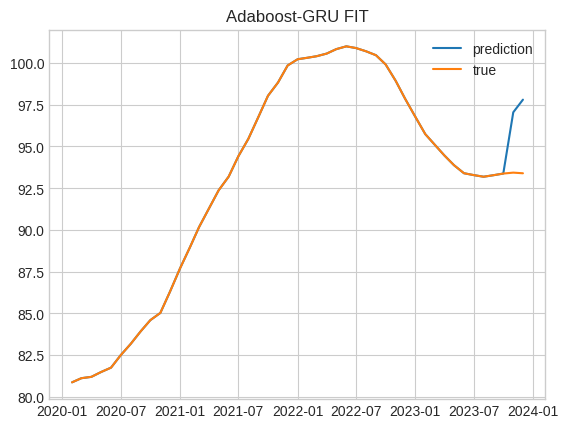

In [96]:
plt.plot(df['pred'], label='prediction')
plt.plot(df['housing_trading'], label='true')
plt.legend()
plt.title('Adaboost-GRU FIT')
plt.show()

In [97]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(df['housing_trading'], predicted))
print("RMSE:", rmse)

RMSE: 0.8315425110869401
